In [1]:
# %load main.py
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from helper import *

In [2]:
# MODEL_PATH="/media/tianning/DATA/Pre_Model/SketchKeras/mod.h5"
# mod = load_model(MODEL_PATH)

## UTLITS

In [3]:
from tqdm import tnrange, tqdm_notebook

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
def gray_print(img):
    plt.imshow(img,'gray')
def rgb_print(img):
    img_rgb=img[:,:,[2,1,0]]
    plt.imshow(img_rgb,'gray')

import os
def under_file(file_dir):
    if not os.path.isfile(file_dir):
        filepaths=[]
        for filename in os.listdir(file_dir):
            if "csv" not in filename:
                filepath=os.path.join(file_dir,filename)
                filepaths.extend(under_file(filepath))
    else:
        filepaths=[file_dir]
    return filepaths


def grab_pic(func,paths,array):
    rowm,colm=array.shape
    thiscol=[]
    for i in range(rowm):
        thisline=[]
        for j in range(colm):
            pic= func(paths,array[i][j],0.01)
            thisline.append(pic)
        thiscol.append(np.concatenate(thisline,axis=1))
    return np.concatenate(thiscol)

### test code

## Show

#### function

In [5]:
def preprocess(from_mat):
    width = float(from_mat.shape[1])
    height = float(from_mat.shape[0])
    new_width = 0
    new_height = 0
    if (width > height):
        from_mat = cv2.resize(from_mat, (512, int(512 / width * height)), interpolation=cv2.INTER_AREA)
        new_width = 512
        new_height = int(512 / width * height)
    else:
        from_mat = cv2.resize(from_mat, (int(512 / height * width), 512), interpolation=cv2.INTER_AREA)
        new_width = int(512 / height * width)
        new_height = 512
        
def recover(mat,threshold=0.07):
    mat = mat.astype(np.float)
    mat[mat<threshold] = 0
    mat = - mat + 1
    mat = mat * 255.0
    mat[mat < 0] = 0
    mat[mat > 255] = 255
    mat=mat.astype(np.uint8)
    mat = ndimage.median_filter(mat, 1)
    out =cv2.cvtColor(mat, cv2.COLOR_GRAY2RGB)
    return out

def get_sketch(image,threshold=0.07):
    from_mat=image
    width = float(from_mat.shape[1])
    height = float(from_mat.shape[0])
    new_width = 0
    new_height = 0
    if (width > height):
        from_mat = cv2.resize(from_mat, (512, int(512 / width * height)), interpolation=cv2.INTER_AREA)
        new_width = 512
        new_height = int(512 / width * height)
    else:
        from_mat = cv2.resize(from_mat, (int(512 / height * width), 512), interpolation=cv2.INTER_AREA)
        new_width = int(512 / height * width)
        new_height = 512
    from_mat = from_mat.transpose((2, 0, 1))
    light_map = np.zeros(from_mat.shape, dtype=np.float)
    for channel in range(3):light_map[channel] = get_light_map_single(from_mat[channel])
    light_map = normalize_pic(light_map)
    light_map = resize_img_512_3d(light_map)
    line_mat = mod.predict(light_map, batch_size=1)
    line_mat = line_mat.transpose((3, 1, 2, 0))[0]
    line_mat = line_mat[0:int(new_height), 0:int(new_width), :]
    line_mat = np.amax(line_mat, 2)
    
    return recover(line_mat,threshold)

#import pylab
#pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小

def get_edge(image,para=(7,7)):
    pic_preprocessed  = cv2.cvtColor(cv2.GaussianBlur(image, para, 0), cv2.COLOR_BGR2GRAY)
    pic_edges = cv2.bitwise_not(cv2.Canny(pic_preprocessed, threshold1=20, threshold2=60))
    pic_out=cv2.cvtColor(pic_edges, cv2.COLOR_GRAY2RGB)
    return pic_out

def get_edge2(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    ret, thr = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
    edges = cv2.Canny(img, ret * 0.5, ret)
    out=cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return out

def prinable(sketch,h,w):
    out =cv2.resize(sketch,(h,w))
    if len(sketch.shape)==2:out=cv2.merge([sketch,sketch,sketch])
    return out.astype('int')

def highPass(img):
    gray = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (0, 0), 10)
    highPass = gray.astype(int) - blur.astype(int) + 255
    highPass[highPass < 0 ] = 0
    highPass[highPass > 255] = 255
    highPass = highPass.astype(np.float)
    return highPass

def test_look(imagepaths,num,threshold=0.07):
    image=cv2.imread(imagepaths[num])
    w,h,_=image.shape
    sketch  =get_sketch(image,threshold);
    sketch =prinable(sketch,h,w)
    row1=np.concatenate([image,sketch],axis=1)
    return row1

def train_look(pairpaths,num,threshold=0.07):
    pair = pairpaths[num]
    image= cv2.imread(pair[0])
    w,h,_ =image.shape
    sketch  =get_sketch(image,threshold);
    sketch  =prinable(sketch,h,w)
    true_sketch=cv2.imread(pair[1])
    true_sketch=highPass(true_sketch)
    true_sketch=prinable(true_sketch,h,w)
    row1=np.concatenate([image,sketch,true_sketch],axis=1)
    return row1

#### main code

In [6]:
basedir="/media/tianning/DATA/human_data_sets/CAF/"
test_paths=under_file(basedir)

In [7]:
len(test_paths)

8303

In [12]:
basedir="/media/tianning/DATA/human_data_sets/HD-CelebA-Cropper/path_to_dataset/data_crop_256_jpg/"
test_paths=under_file(basedir)
imagepaths=test_paths

In [13]:
basedir_o="/media/tianning/DATA/human_data_sets/HD-CelebA-Cropper/path_to_dataset/data/"
test_paths_o=under_file(basedir_o)
imagepaths_o=test_paths_o

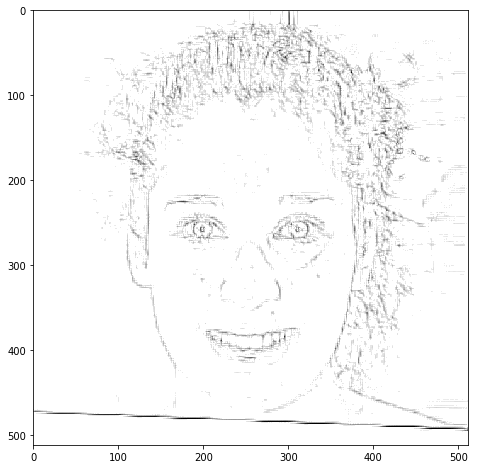

In [68]:
sketch = get_sketch(image)
gray_print(sketch)

In [71]:
basedir="/media/tianning/DATA/human_data_sets/CAF/"
test_paths=under_file(basedir)
imagepaths=test_paths

In [74]:
leng=len(imagepaths)
for i in tnrange(leng, desc='1st loop'):
    path=imagepaths[i]
    image=cv2.imread(path)
    w,h,_=image.shape
    sketch = get_sketch(image,0.07)
    _=cv2.imwrite("/media/tianning/DATA/sketch_super_resolution/512/source_"+str(i)+'.jpg',image)
    _=cv2.imwrite("/media/tianning/DATA/sketch_super_resolution/512/target_"+str(i)+'.jpg',sketch)

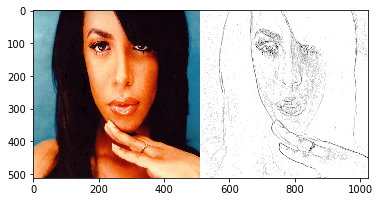

In [24]:
image=cv2.imread(imagepaths[num])
w,h,_=image.shape
sketch  =get_sketch(image,0.);
row1=np.concatenate([image,sketch],axis=1)
row2=np.concatenate([edge,edge2],axis=1)
combine=np.concatenate([row1,row2])
cv2.imwrite('test.jpg',row1)
rgb_print(row1)

## Post-Train

#### function

In [8]:
def unifsize(image):
    from_mat=image
    width = float(from_mat.shape[1])
    height = float(from_mat.shape[0])
    new_width = 0
    new_height = 0
    if (width > height):
        from_mat = cv2.resize(from_mat, (512, int(512 / width * height)), interpolation=cv2.INTER_AREA)
        new_width = 512
        new_height = int(512 / width * height)
    else:
        from_mat = cv2.resize(from_mat, (int(512 / height * width), 512), interpolation=cv2.INTER_AREA)
        new_width = int(512 / height * width)
        new_height = 512
    return from_mat

def pre_process_inp(image):
    from_mat = unifsize(image)
    from_mat = from_mat.transpose((2, 0, 1))
    light_map = np.zeros(from_mat.shape, dtype=np.float)
    for channel in range(3):light_map[channel] = get_light_map_single(from_mat[channel])
    light_map = normalize_pic(light_map)
    light_map = resize_img_512_3d(light_map)
    return light_map

def rotate(image, angle, center=None, scale=1.0):
    # 获取图像尺寸
    (h, w) = image.shape[:2]
    if center is None:center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def add_data(pair):
    photo,sketch=pair
    #angle=np.floor(np.random.rand()*360)
    #photo = rotate(photo,angle)
    #sketch= rotate(sketch,angle)
    if np.random.rand() > 0.5:
        photo = cv2.flip(photo, 1)
        sketch = cv2.flip(sketch, 1)
    if np.random.rand() > 0.5:
        photo = cv2.flip(photo, 0)
        sketch = cv2.flip(sketch, 0)
    return check_input_form_single(photo),check_input_form_single(sketch)

def check_input_form_single(image):
    shape=image.shape
    dim  = len(shape)
    if dim == 3:
        a,b,c = shape
        if a==1:image=image.reshape(a,b,c,1)
        if c==1:image=image.reshape(1,a,b,c)
        if b==1:raise NotImplementedError("bad image:a,b,c=shape;b=1")
    if dim == 2:
        a,b = shape
        image=image.reshape(1,a,b,1)
    a,b,c,d=image.shape
    if a==1 and d==1 and b==c and b>1:
        return image
    else:
        raise NotImplementedError("bad image size:(%d,%d,%d,%d)" %(a,b,c,d))

def get_sample(dataset,batch_size):
    np.random.shuffle(dataset)
    inps=[]
    outs=[]
    for i in range(batch_size):
        inp,out= add_data(dataset[i])
        inps.append(inp)
        outs.append(out)
    return np.concatenate(inps),np.concatenate(outs)

#### for human reinfore train
def get_sample_from_path(dataset,batch_size):
    np.random.shuffle(dataset)
    inps=[]
    outs=[]

    for i in range(batch_size):
        photo_path,sketch_path=dataset[i]
        photo_o = cv2.imread(photo_path)
        sketch_o= cv2.imread(sketch_path)
        photo   = pre_process_inp(photo_o)
        sketch  = get_gray_map(unifsize(sketch_o))
        sketch  = resize_img_512(sketch)
        ch=np.random.randint(0,3)
        try:
            inp,out= add_data([photo[ch],sketch])
            inps.append(inp)
            outs.append(out)
        except:
            print(i)
    return np.concatenate(inps),np.concatenate(outs)

#### Main code

In [8]:
DATA_PATH_1="/media/tianning/DATA/human_data_sets/CUHK/sketches/"
DATA_PATH_2="/media/tianning/DATA/human_data_sets/CUHK/photos/"
photo_names=[name.split('.')[0] for name in os.listdir(DATA_PATH_2)]

In [12]:
#####################
####load path########
#####################
file_dir=DATA_PATH_2
for filename in os.listdir(file_dir):
    filename_s=filename.lower()
    filepath=os.path.join(file_dir,filename)
    filepath_s=os.path.join(file_dir,filename_s)
    os.rename(filepath,filepath_s)

pair_paths=[]
for name in photo_names:
    photo_path =os.path.join(DATA_PATH_2,name+'.jpg')
    sketch_path=os.path.join(DATA_PATH_1,name+'-sz1.jpg')
    if os.path.exists(sketch_path):
        pair_paths.append((photo_path,sketch_path))
        
combine_path=pair_paths[:]
data_dir="/media/tianning/DATA/anime_data_sets/pixiv_data/pair_128/"
pair_list=os.listdir(data_dir)
leng=len(pair_list)/2
output={}
for name in pair_list:
    num,sign=name.strip().split("_")
    sign=sign.strip('.')[0]
    path=os.path.join(data_dir,name)
    if num not in output:output[num]={}
    output[num][sign]=path
other=[[output[key]['g'],output[key]['c']] for key in output]    
# combine_path.extend(other[:500])        

image_pair=[]
for photo_path,sketch_path in pair_paths:
    photo=pre_process_inp(cv2.imread(photo_path))
    sketch=resize_img_512(get_light_map(cv2.imread(sketch_path)))
    R,G,B =photo
    image_pair.append([R,sketch])
    image_pair.append([G,sketch])
    image_pair.append([B,sketch])

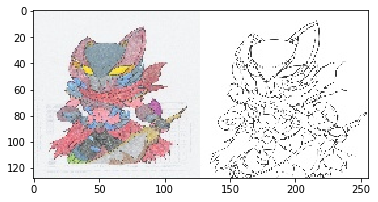

In [46]:
i=1990
a,b=other[i]
im1=cv2.imread(a)
im2=cv2.imread(b)
cb =np.concatenate([im1,im2],axis=1)
rgb_print(cb)

In [10]:
basedir="/media/tianning/DATA/human_data_sets/CAF/"
test_paths=under_file(basedir)

In [13]:
anime_paths=other

In [25]:
train_picked=np.random.randint(0,len(pair_paths),(3,3));
test_picked =np.random.randint(0,len(test_paths),(3,3));
anime_picked=np.random.randint(0,len(anime_paths),(3,3));

In [21]:
from tensorflow.keras import backend as K
K.clear_session()

In [22]:
MODEL_PATH="save_model/my_model_12999.h5"
mod = load_model(MODEL_PATH)

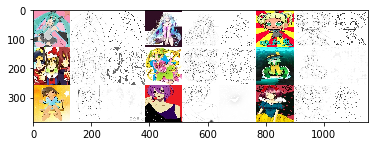

In [27]:
anime_grab=grab_pic(train_look,anime_paths,anime_picked)
rgb_print(anime_grab)

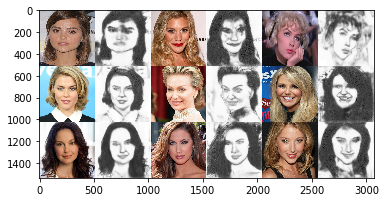

In [26]:
test_grab=grab_pic(test_look,test_paths,test_picked)
rgb_print(test_grab)

In [47]:
# start=13000
# tot_epch=20000
# write_epch=1000
# save_epch=1000
# for i in tnrange(start,tot_epch+start, desc='1st loop'):
#     #inp,tar=get_sample(image_pair,4)
#     inp,tar=get_sample_from_path(combine_path,4)
#     loss   =mod.train_on_batch(inp,tar)
#     with open('log','w') as f:
#         f.write(str(i)+'/'+str(tot_epch))
#     if i%write_epch == 0:
#         train_grab=grab_pic(train_look,pair_paths,train_picked)
#         test_grab =grab_pic(test_look,test_paths,test_picked)
#         anime_grab=grab_pic(train_look,anime_paths,anime_picked)
#         cv2.imwrite('image/train_look_'+str(i)+'.jpg',train_grab)
#         cv2.imwrite('image/test_look_'+str(i)+'.jpg',test_grab)
#         cv2.imwrite('image/anime_look_'+str(i)+'.jpg',anime_grab)
#     if i%save_epch == save_epch-1:mod.save('save_model/my_model_'+str(i)+'.h5')
# train_grab=grab_pic(train_look,pair_paths,train_picked)
# test_grab=grab_pic(test_look,test_paths,test_picked)
# anime_grab=grab_pic(train_look,anime_paths,anime_picked)
# cv2.imwrite('image/train_look_'+str(i)+'.jpg',train_grab)
# cv2.imwrite('image/test_look_'+str(i)+'.jpg',test_grab)
# cv2.imwrite('image/anime_look_'+str(i)+'.jpg',anime_grab)

True

Show Result

In [ ]:
K.clear_session()
MODEL_PATH="/home/tianning/Documents/MachineLearning/sketchKeras/Case_Job_1/save_model/my_model_12999.h5"
mod = load_model(MODEL_PATH)

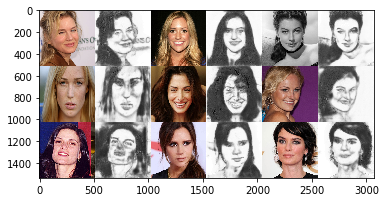

In [43]:
test_picked =np.random.randint(0,len(test_paths),(3,3));
rgb_print(grab_pic(test_look,test_paths,test_picked))

In [11]:
def show_combine(image,others=None):
    w,h,_=image.shape
    sketch= get_sketch(image)
    sketch=cv2.resize(sketch,(h,w))
    others=cv2.resize(others,(h,w))
    if others is not None:
        combine=np.concatenate([image,sketch,others],axis=1)
    else:
        combine=np.concatenate([image,sketch],axis=1)
    rgb_print(combine)

In [9]:
TEST_ANIME_DIR="/media/tianning/DATA/anime_data_sets/GirlsManifold-master/data/detected_faces/"
Sket_Anime_dir="/media/tianning/DATA/anime_data_sets/GirlsManifold-master/ske_256/"
names= os.listdir(TEST_ANIME_DIR)

In [33]:
from tensorflow.keras import backend as K
K.clear_session()
MODEL_PATH="save_model/my_model_32999.h5"
mod = load_model(MODEL_PATH)

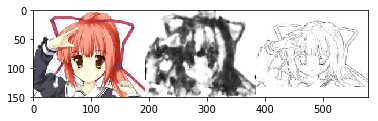

In [34]:
i=3200
name = names[i]
anime_path = TEST_ANIME_DIR + name
o_ske_path = Sket_Anime_dir + str(i)+'.jpg'
image = cv2.imread(anime_path)
o_ske = cv2.imread(o_ske_path)
show_combine(image,o_ske)

In [13]:
anime_paths=other

In [25]:
train_picked=np.random.randint(0,len(pair_paths),(3,3));
test_picked =np.random.randint(0,len(test_paths),(3,3));
anime_picked=np.random.randint(0,len(anime_paths),(3,3));

In [21]:
from tensorflow.keras import backend as K
K.clear_session()

In [13]:
MODEL_PATH="save_model/my_model_32999.h5"
mod = load_model(MODEL_PATH)

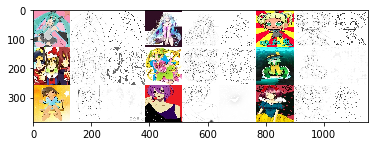

In [27]:
anime_grab=grab_pic(train_look,anime_paths,anime_picked)
rgb_print(anime_grab)